# Dask through Jupyter Notebooks

This notebook will guide you through using Dask to analyze NanoAOD root files using a Slurm Cluster on SubMIT. This notebook utilizes a conda environment and then exports that environment in the slurm jobs. Follow the README for instructions on the conda environment. 

In [1]:
import os
import sys
import json
import time
import random
import numpy as np
from coffea import hist, processor

from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report

/work/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
/work/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


We set up a coffea ABC Processor to analyze the ROOT files. Here we grab the Muon and Electron collection and add some simple selections using awkward.

In [2]:
import awkward as ak
import vector
vector.register_awkward()

class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str) -> None:
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        #Set up for the histograms
        self._accumulator = processor.dict_accumulator({
            "N_Muons": hist.Hist(
                "Events",
                hist.Bin("NMuons", "Num Muons", 10, 0, 10)
            ),   
            "N_Electrons": hist.Hist(
                "Events",
                hist.Bin("NElectrons", "Num Electrons", 10, 0, 10)
            ), 
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        Muons = ak.zip({
              "pt": events.Muon.pt,
              "eta": events.Muon.eta,
              "phi": events.Muon.phi,
              "mass": events.Muon.mass
        }, with_name="Momentum4D") 
        cut = (events.Muon.pt > 10) & \
            (abs(events.Muon.eta) <= 2.4) & \
            (events.Muon.mediumId == 1) 
        Muons = Muons[cut]
        
        output["N_Muons"].fill(
            NMuons = ak.num(Muons),
        ) 
        
        Electrons = ak.zip({
               "pt": events.Electron.pt,
               "eta": events.Electron.eta,
               "phi": events.Electron.phi,
               "mass": events.Electron.mass
        }, with_name="Momentum4D") 
        cut_ele = (events.Electron.pt > 10) & \
            (abs(events.Electron.eta) <= 2.4) & \
            (events.Electron.mvaFall17V2Iso_WP90 == 1) 
        Electrons = Electrons[cut_ele]
        
        output["N_Electrons"].fill(
            NElectrons = ak.num(Electrons),
        ) 
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

The following section defines additional parts of the slurm Dask job. Here we source the bashrc to prepare Conda. We also pass in the x509 proxy. In order to share the proxy across the SubMIT machines you should move your proxy to your HOME directory.

In [4]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate dask',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u206148'
]

extra_args=[
     "--output=dask_job_output_%j.out",
     "--error=dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

In [5]:
n_port       = 6820
w_port       = 9765
cores        = 1
processes    = 1
memory       = "5 GB"
chunksize    = 15000
maxchunks    = None

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [6]:
#Set up the processor
processor_instance = Simple_Process(isMC=1, era='2018', sample='test')

# load dataset
with open("Rucio_JSON_Maker/sample.json") as f:
    sample_dict = json.load(f)
for key in sample_dict.keys():
    sample_dict[key] = sample_dict[key][:]

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [7]:
if not check_port(n_port):
    raise RuntimeError("Port '{}' is occupied on this node. Try another one.".format(n_port))

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8000,
              'host': socket.gethostname()
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

/work/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 14802 instead
  warnings.warn(


In [8]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

<Client: 'tcp://18.12.2.18:6820' processes=0 threads=0, memory=0 B>


# Running the processor
Now we will run the code with a performance report. This will analyze all of the input ROOT files and will store the histograms in output. Then we can analyze the output and make plots.

In [10]:
with performance_report(filename="dask-report.html"):
    output = processor.run_uproot_job(sample_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.dask_executor,
             executor_args={
                           'client': client,
                           #'skipbadfiles': skipbadfiles,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 10,
                           'retries': 3,
                           },
             chunksize=chunksize,
             maxchunks=maxchunks)

In [10]:
output['N_Muons']

<Hist (NMuons) instance at 0x7f66c4e3aac0>

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Num Muons', ylabel='Events'>

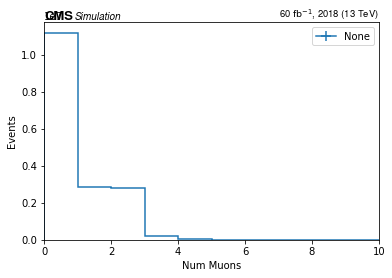

In [13]:
import mplhep as hep
#import hist
from coffea import hist

# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False, lumi=60, year=2018)

import matplotlib.pyplot as plt
hist.plot1d(output['N_Muons'])

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Num Electrons', ylabel='Events'>

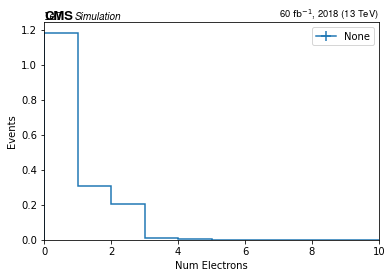

Remove worker <WorkerState 'tcp://18.12.2.9:40586', name: SLURMCluster-123, status: running, memory: 0, processing: 0>
Lost all workers
Register worker <WorkerState 'tcp://18.12.2.18:23426', name: SLURMCluster-123, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:23426


In [14]:
hep.cms.label(data=False, lumi=60, year=2018)
hist.plot1d(output['N_Electrons'])